# Reinforcement Learning and Business Optimization

This notebook combines comprehensive reinforcement learning concepts and practical business use-case examples for marketing campaign optimization. It covers:
 - RL fundamentals: MDPs, value functions, Q-learning, and neural network function approximators.
 - A business simulation: Multi-armed bandit approach to optimize marketing campaigns with various strategies (random, greedy, epsilon-greedy, UCB).
 - An assignment with automated pass/fail criteria based on simulation performance.
 - Theoretical reflection questions to help students understand and reflect on the material.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Set a random seed for reproducibility
random.seed(42)
np.random.seed(42)

## Section 1: Reinforcement Learning Theory and Simulation

### 1.1: Simple Environment Simulation

We'll begin with a basic environment that simulates different rewards based on actions taken.

In [2]:
def simple_environment(action):
    """Simulate a simple environment with two actions.
    Action 0: reward=1 with 50% probability.
    Action 1: reward=1 with 80% probability.
    """
    if action == 0:
        return 1 if random.random() < 0.5 else 0
    elif action == 1:
        return 1 if random.random() < 0.8 else 0
    return 0


def run_agent(steps=1000):
    actions = [0, 1]
    action_rewards = {0: 0, 1: 0}
    action_counts = {0: 0, 1: 0}
    for _ in range(steps):
        action = random.choice(actions)
        reward = simple_environment(action)
        action_rewards[action] += reward
        action_counts[action] += 1
    avg_rewards = {a: action_rewards[a] / action_counts[a] if action_counts[a] != 0 else 0 for a in actions}
    return avg_rewards


# Test the environment
avg_rewards = run_agent(1000)
print("Average rewards after 1000 steps (Simple Environment):", avg_rewards)

Average rewards after 1000 steps (Simple Environment): {0: 0.4874476987447699, 1: 0.7758620689655172}


### 1.2: Simple MDP Example

Now we'll implement a simple Markov Decision Process (MDP) with states and actions.

In [3]:
class SimpleMDP:
    """Simple MDP with states 0 to 4, where action 1 moves right and -1 moves left.
    Reward of 1 is given when state reaches 4.
    """
    def __init__(self):
        self.states = list(range(5))
        self.current_state = 0

    def reset(self):
        self.current_state = 0
        return self.current_state

    def step(self, action):
        next_state = self.current_state + action
        next_state = max(0, min(4, next_state))
        reward = 1 if next_state == 4 else 0
        self.current_state = next_state
        return next_state, reward


# Test the MDP
env = SimpleMDP()
state = env.reset()
print("Initial state (MDP):", state)
next_state, reward = env.step(1)
print("After taking action 1, next state:", next_state, "Reward:", reward)

Initial state (MDP): 0
After taking action 1, next state: 1 Reward: 0


### 1.3: Inverse Reinforcement Learning - Generate Expert Trajectory

Expert trajectories can be used for inverse reinforcement learning where we try to infer the reward function.

In [4]:
def generate_expert_trajectory(env, expert_policy, steps=10):
    trajectory = []
    state = env.reset()
    for _ in range(steps):
        action = expert_policy(state)
        next_state, reward = env.step(action)
        trajectory.append((state, action, next_state, reward))
        state = next_state
    return trajectory


def expert_policy(state):
    return 1  # Always move right


# Generate and display an expert trajectory
env = SimpleMDP()
trajectory = generate_expert_trajectory(env, expert_policy, steps=10)
print("Expert Trajectory:")
for t in trajectory:
    print(t)

Expert Trajectory:
(0, 1, 1, 0)
(1, 1, 2, 0)
(2, 1, 3, 0)
(3, 1, 4, 1)
(4, 1, 4, 1)
(4, 1, 4, 1)
(4, 1, 4, 1)
(4, 1, 4, 1)
(4, 1, 4, 1)
(4, 1, 4, 1)


### 1.4: Policy Evaluation for a 3-State MDP (Value Function)

Now let's implement policy evaluation to compute the value function.

In [5]:
def policy_evaluation(P, V, gamma, theta=1e-4, states=[0,1,2]):
    while True:
        delta = 0
        for s in states:
            if s not in P or not P[s]:
                continue
            v = V[s]
            V[s] = sum(prob * (reward + gamma * V[next_state]) for next_state, prob, reward in P[s])
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V


# Test policy evaluation
states = [0, 1, 2]
P = {
    0: [(1, 1.0, 0)],
    1: [(0, 0.5, 0), (2, 0.5, 1)],
    2: []  # terminal state
}
gamma = 0.9
V = {s: 0 for s in states}
V = policy_evaluation(P, V, gamma)
print("Computed Value Function:", V)

Computed Value Function: {0: 0.7562661545671955, 1: 0.840319769555238, 2: 0}


### 1.5: Q-Learning Simulation Example

Q-learning is a model-free reinforcement learning algorithm to learn the value of an action in a particular state.

In [6]:
class SimpleQLearningEnv:
    def __init__(self):
        self.states = list(range(5))
        self.current_state = 0

    def reset(self):
        self.current_state = 0
        return self.current_state

    def step(self, action):
        next_state = self.current_state + action
        next_state = max(0, min(4, next_state))
        reward = 1 if next_state == 4 else 0
        self.current_state = next_state
        return next_state, reward


def q_learning(episodes=1000, epsilon=0.2):
    env = SimpleQLearningEnv()
    num_states = 5
    actions = [-1, 1]  # left and right moves
    Q_table = np.zeros((num_states, len(actions)))
    alpha = 0.1
    gamma = 0.9
    for ep in range(episodes):
        state = env.reset()
        done = False
        while not done:
            if np.random.rand() < epsilon:
                action_index = np.random.choice(len(actions))
            else:
                action_index = np.argmax(Q_table[state])
            action = actions[action_index]
            next_state, reward = env.step(action)
            best_next_action = np.argmax(Q_table[next_state])
            Q_table[state, action_index] += alpha * (reward + gamma * Q_table[next_state, best_next_action] - Q_table[state, action_index])
            state = next_state
            if state == 4:
                done = True
    return Q_table


# Run Q-learning
Q_table = q_learning(episodes=1000, epsilon=0.2)
print("Learned Q-table:")
print(Q_table)

Learned Q-table:
[[0.65609964 0.729     ]
 [0.65609865 0.81      ]
 [0.72898573 0.9       ]
 [0.80997478 1.        ]
 [0.         0.        ]]


### 1.6: Neural Network Function Approximator for Q-values using PyTorch

For complex state spaces, neural networks can approximate Q-values.

In [7]:
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    
    class QNetwork(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(QNetwork, self).__init__()
            self.fc = nn.Sequential(
                nn.Linear(input_dim, 16),
                nn.ReLU(),
                nn.Linear(16, output_dim)
            )
        def forward(self, x):
            return self.fc(x)

    input_dim = 1
    output_dim = 2
    q_net = QNetwork(input_dim, output_dim)
    optimizer = optim.Adam(q_net.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()

    states = torch.tensor([[0.0], [1.0], [2.0], [3.0]], dtype=torch.float32)
    target_Q = torch.tensor([[0.5, 0.7],
                              [0.6, 0.8],
                              [0.7, 0.9],
                              [0.8, 1.0]], dtype=torch.float32)
    for epoch in range(200):
        optimizer.zero_grad()
        outputs = q_net(states)
        loss = loss_fn(outputs, target_Q)
        loss.backward()
        optimizer.step()
    print("Trained Q-network outputs:")
    print(q_net(states).detach().numpy())
except ImportError:
    print("PyTorch not installed. Skipping Q-network demonstration.")

Trained Q-network outputs:
[[0.49844363 0.70475715]
 [0.60100347 0.7931054 ]
 [0.70289737 0.89796406]
 [0.7977777  1.0036739 ]]


## Section 2: Business Context - Marketing Campaign Optimization Using Multi-Armed Bandit

### 2.1: Setup for Marketing Campaign Simulation

We'll simulate marketing campaigns with different conversion rates.

In [8]:
true_conversion_rates = [0.2, 0.5, 0.7]
num_campaigns = len(true_conversion_rates)

def get_campaign_result(campaign_index):
    """Return 1 (conversion) or 0 (no conversion) based on the campaign's true conversion rate."""
    if random.random() < true_conversion_rates[campaign_index]:
        return 1
    return 0


# Test the campaign simulation
test_results = [get_campaign_result(0) for _ in range(1000)]
print(f"Campaign 1 test conversion rate: {sum(test_results)/len(test_results):.3f} (expected ~{true_conversion_rates[0]})")

Campaign 1 test conversion rate: 0.193 (expected ~0.2)


### 2.2: Multi-Armed Bandit Simulation using Epsilon-Greedy

In [9]:
def simulate_bandit(epsilon, steps=1000):
    np.random.seed(42)
    true_probs = true_conversion_rates
    num_arms = len(true_probs)
    Q_estimates = np.zeros(num_arms)
    counts = np.zeros(num_arms)
    rewards = []
    for step in range(steps):
        if np.random.rand() < epsilon:
            chosen_arm = np.random.choice(num_arms)
        else:
            chosen_arm = np.argmax(Q_estimates)
        reward = 1 if np.random.rand() < true_probs[chosen_arm] else 0
        counts[chosen_arm] += 1
        Q_estimates[chosen_arm] = Q_estimates[chosen_arm] + (reward - Q_estimates[chosen_arm]) / counts[chosen_arm]
        rewards.append(reward)
    average_reward = np.mean(rewards)
    return average_reward, Q_estimates, counts


# Test bandit simulation
avg_reward, Q_estimates, counts = simulate_bandit(epsilon=0.1, steps=1000)
print("Epsilon=0.1 Bandit Simulation:")
print("Average Reward:", avg_reward)
print("Estimated Q-values:", Q_estimates)
print("Counts:", counts)

Epsilon=0.1 Bandit Simulation:
Average Reward: 0.671
Estimated Q-values: [0.22916667 0.56097561 0.69923161]
Counts: [ 48.  41. 911.]


### 2.3: Other Campaign Selection Strategies

Let's implement and compare different strategies for selecting marketing campaigns.

In [10]:
def random_strategy(num_simulations=1000):
    conversions = 0
    campaign_counts = np.zeros(num_campaigns)
    for _ in range(num_simulations):
        campaign = random.randint(0, num_campaigns-1)
        result = get_campaign_result(campaign)
        conversions += result
        campaign_counts[campaign] += 1
    print("Random Strategy Results:")
    print(f"Total Conversions: {conversions} out of {num_simulations} ({conversions/num_simulations:.3f})")
    print("Campaign Selection Counts:", campaign_counts)
    return conversions, campaign_counts


def greedy_strategy(num_simulations=1000):
    conversions = 0
    campaign_counts = np.zeros(num_campaigns)
    campaign_conversions = np.zeros(num_campaigns)
    # Initial exploration: try each campaign once
    for campaign in range(num_campaigns):
        result = get_campaign_result(campaign)
        conversions += result
        campaign_counts[campaign] += 1
        campaign_conversions[campaign] += result
    for _ in range(num_simulations - num_campaigns):
        conversion_rates = campaign_conversions / campaign_counts
        campaign = np.argmax(conversion_rates)
        result = get_campaign_result(campaign)
        conversions += result
        campaign_counts[campaign] += 1
        campaign_conversions[campaign] += result
    print("Greedy Strategy Results:")
    print(f"Total Conversions: {conversions} out of {num_simulations} ({conversions/num_simulations:.3f})")
    print("Campaign Selection Counts:", campaign_counts)
    print("Estimated Conversion Rates:", campaign_conversions / campaign_counts)
    return conversions, campaign_counts, campaign_conversions


def epsilon_greedy_strategy(epsilon, num_simulations=1000):
    conversions = 0
    campaign_counts = np.zeros(num_campaigns)
    campaign_conversions = np.zeros(num_campaigns)
    history = []
    # Initial exploration: try each campaign once
    for campaign in range(num_campaigns):
        result = get_campaign_result(campaign)
        conversions += result
        campaign_counts[campaign] += 1
        campaign_conversions[campaign] += result
        history.append(conversions / (campaign + 1))
    for i in range(num_simulations - num_campaigns):
        if random.random() < epsilon:
            campaign = random.randint(0, num_campaigns-1)
        else:
            conversion_rates = campaign_conversions / campaign_counts
            campaign = np.argmax(conversion_rates)
        result = get_campaign_result(campaign)
        conversions += result
        campaign_counts[campaign] += 1
        campaign_conversions[campaign] += result
        history.append(conversions / (i + num_campaigns + 1))
    print(f"Epsilon-Greedy (ε={epsilon}) Strategy Results:")
    print(f"Total Conversions: {conversions} out of {num_simulations} ({conversions/num_simulations:.3f})")
    print("Campaign Selection Counts:", campaign_counts)
    print("Estimated Conversion Rates:", campaign_conversions / campaign_counts)
    return conversions, campaign_counts, campaign_conversions, history


def ucb_strategy(num_simulations=1000, c=2.0):
    conversions = 0
    campaign_counts = np.zeros(num_campaigns)
    campaign_conversions = np.zeros(num_campaigns)
    history = []
    # Initial exploration: try each campaign once
    for campaign in range(num_campaigns):
        result = get_campaign_result(campaign)
        conversions += result
        campaign_counts[campaign] += 1
        campaign_conversions[campaign] += result
        history.append(conversions / (campaign + 1))
    for i in range(num_simulations - num_campaigns):
        t = i + num_campaigns
        ucb_values = np.zeros(num_campaigns)
        for j in range(num_campaigns):
            if campaign_counts[j] > 0:
                exploitation_term = campaign_conversions[j] / campaign_counts[j]
                exploration_term = c * np.sqrt(np.log(t) / campaign_counts[j])
                ucb_values[j] = exploitation_term + exploration_term
            else:
                ucb_values[j] = float('inf')
        campaign = np.argmax(ucb_values)
        result = get_campaign_result(campaign)
        conversions += result
        campaign_counts[campaign] += 1
        campaign_conversions[campaign] += result
        history.append(conversions / (t + 1))
    print(f"UCB Strategy (c={c}) Results:")
    print(f"Total Conversions: {conversions} out of {num_simulations} ({conversions/num_simulations:.3f})")
    print("Campaign Selection Counts:", campaign_counts)
    print("Estimated Conversion Rates:", campaign_conversions / campaign_counts)
    return conversions, campaign_counts, campaign_conversions, history


# Test different strategies
print("\nTesting Random Strategy:")
random_results = random_strategy(1000)
print("\nTesting Greedy Strategy:")
greedy_strategy(1000)
for eps in [0.0, 0.1, 0.3, 0.5]:
    print(f"\nTesting Epsilon-Greedy Strategy with epsilon={eps}:")
    epsilon_greedy_strategy(eps, 1000)
print("\nTesting UCB Strategy:")
ucb_strategy(1000, c=1.0)


Testing Random Strategy:
Random Strategy Results:
Total Conversions: 487 out of 1000 (0.487)
Campaign Selection Counts: [315. 312. 373.]

Testing Greedy Strategy:
Greedy Strategy Results:
Total Conversions: 709 out of 1000 (0.709)
Campaign Selection Counts: [  1.   3. 996.]
Estimated Conversion Rates: [0.         0.66666667 0.70983936]

Testing Epsilon-Greedy Strategy with epsilon=0.0:
Epsilon-Greedy (ε=0.0) Strategy Results:
Total Conversions: 719 out of 1000 (0.719)
Campaign Selection Counts: [  1.   1. 998.]
Estimated Conversion Rates: [0.         0.         0.72044088]

Testing Epsilon-Greedy Strategy with epsilon=0.1:
Epsilon-Greedy (ε=0.1) Strategy Results:
Total Conversions: 670 out of 1000 (0.670)
Campaign Selection Counts: [ 40.  59. 901.]
Estimated Conversion Rates: [0.1        0.45762712 0.70921199]

Testing Epsilon-Greedy Strategy with epsilon=0.3:
Epsilon-Greedy (ε=0.3) Strategy Results:
Total Conversions: 635 out of 1000 (0.635)
Campaign Selection Counts: [105.  96. 799.

(676,
 array([ 22., 163., 815.]),
 array([  5.,  96., 575.]),
 [0.0,
  0.5,
  0.6666666666666666,
  0.5,
  0.4,
  0.3333333333333333,
  0.2857142857142857,
  0.25,
  0.3333333333333333,
  0.4,
  0.45454545454545453,
  0.4166666666666667,
  0.46153846153846156,
  0.42857142857142855,
  0.4666666666666667,
  0.5,
  0.47058823529411764,
  0.4444444444444444,
  0.47368421052631576,
  0.5,
  0.5238095238095238,
  0.5,
  0.4782608695652174,
  0.5,
  0.52,
  0.5384615384615384,
  0.5555555555555556,
  0.5714285714285714,
  0.5517241379310345,
  0.5666666666666667,
  0.5806451612903226,
  0.5625,
  0.5454545454545454,
  0.5294117647058824,
  0.5142857142857142,
  0.5,
  0.5135135135135135,
  0.5263157894736842,
  0.5384615384615384,
  0.55,
  0.5609756097560976,
  0.5476190476190477,
  0.5581395348837209,
  0.5681818181818182,
  0.5777777777777777,
  0.5869565217391305,
  0.5957446808510638,
  0.5833333333333334,
  0.5918367346938775,
  0.6,
  0.6078431372549019,
  0.6153846153846154,
  0.6037

### 2.4: Visualization of Strategy Comparison

In [11]:
def plot_strategy_comparison(random_results, eps_results_dict, true_rates=true_conversion_rates):
    strategies = ['Random'] + [f'ε-Greedy (ε={eps})' for eps in eps_results_dict.keys()]
    conversion_rates = [random_results[0] / 1000] + [eps_results_dict[eps][0] / 1000 for eps in eps_results_dict.keys()]
    plt.figure(figsize=(12,6))
    bars = plt.bar(strategies, conversion_rates, color=sns.color_palette("viridis", len(strategies)))
    plt.axhline(y=max(true_rates), color='r', linestyle='--', alpha=0.7, label=f'Best Campaign ({max(true_rates):.2f})')
    plt.axhline(y=sum(true_rates)/len(true_rates), color='gray', linestyle='--', alpha=0.7, label=f'Average Campaign ({sum(true_rates)/len(true_rates):.2f})')
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
    plt.ylim(0, max(true_rates) + 0.1)
    plt.ylabel('Overall Conversion Rate')
    plt.xlabel('Strategy')
    plt.title('Performance Comparison of Campaign Selection Strategies')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()


def plot_learning_curves(eps_history, ucb_history, true_rates=true_conversion_rates):
    plt.figure(figsize=(14,7))
    for eps, history in eps_history.items():
        plt.plot(history, label=f'ε-Greedy (ε={eps})')
    plt.plot(ucb_history, label='UCB', linewidth=2)
    plt.axhline(y=max(true_rates), color='r', linestyle='--', alpha=0.7, label=f'Best Campaign ({max(true_rates):.2f})')
    plt.axhline(y=sum(true_rates)/len(true_rates), color='gray', linestyle='--', alpha=0.7, label=f'Average Campaign ({sum(true_rates)/len(true_rates):.2f})')
    plt.title('Learning Curve: Cumulative Conversion Rate Over Time')
    plt.xlabel('Number of Customers')
    plt.ylabel('Cumulative Conversion Rate')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

Epsilon-Greedy (ε=0.0) Strategy Results:
Total Conversions: 1950 out of 10000 (0.195)
Campaign Selection Counts: [9.998e+03 1.000e+00 1.000e+00]
Estimated Conversion Rates: [0.19503901 0.         0.        ]
Epsilon-Greedy (ε=0.1) Strategy Results:
Total Conversions: 6815 out of 10000 (0.681)
Campaign Selection Counts: [ 341.  321. 9338.]
Estimated Conversion Rates: [0.17888563 0.50778816 0.70582566]
Epsilon-Greedy (ε=0.3) Strategy Results:
Total Conversions: 6284 out of 10000 (0.628)
Campaign Selection Counts: [1005. 1011. 7984.]
Estimated Conversion Rates: [0.2        0.51533136 0.69664329]
Epsilon-Greedy (ε=0.5) Strategy Results:
Total Conversions: 5785 out of 10000 (0.579)
Campaign Selection Counts: [1644. 1644. 6712.]
Estimated Conversion Rates: [0.1770073  0.50182482 0.69561979]
Random Strategy Results:
Total Conversions: 4768 out of 10000 (0.477)
Campaign Selection Counts: [3301. 3328. 3371.]
UCB Strategy (c=1.0) Results:
Total Conversions: 6966 out of 10000 (0.697)
Campaign Sel

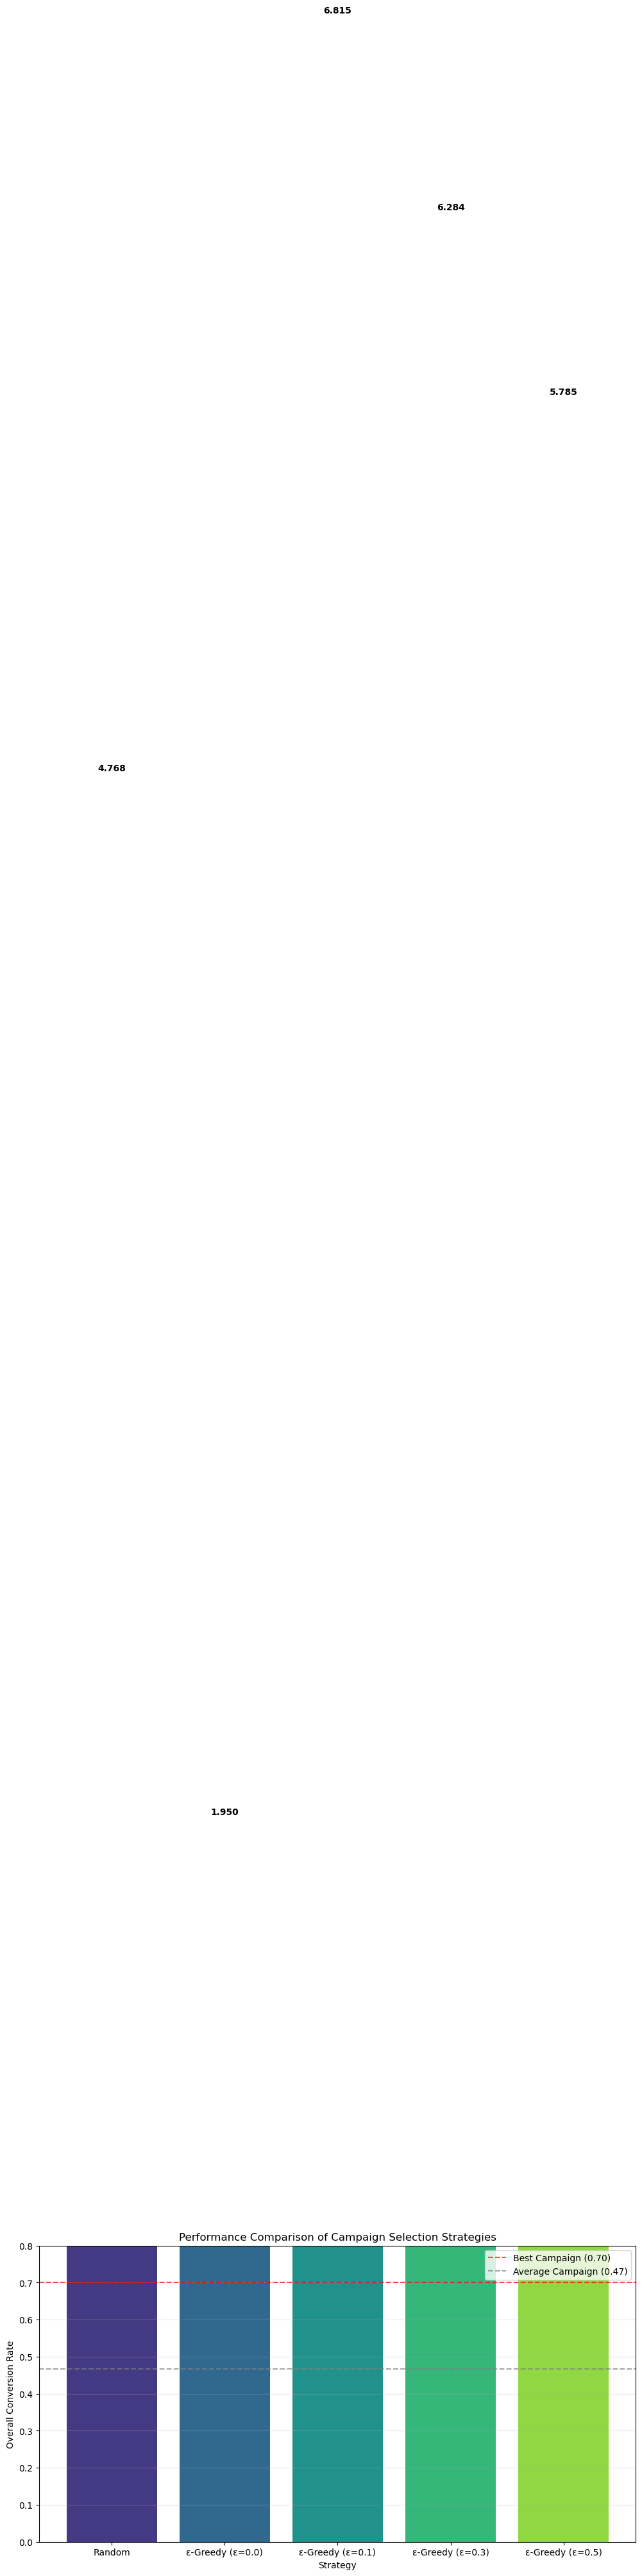

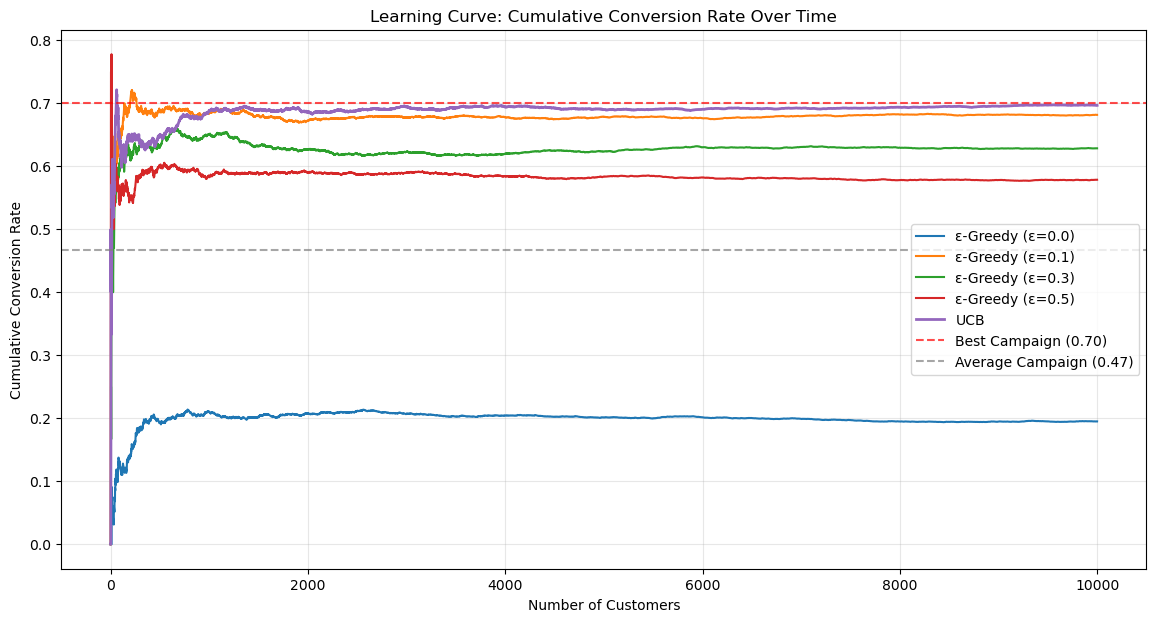

In [12]:
# Run experiments for visualization
eps_values = [0.0, 0.1, 0.3, 0.5]
eps_history = {}
eps_results = {}
for eps in eps_values:
    conv, counts, convs, history = epsilon_greedy_strategy(eps, 10000)
    eps_history[eps] = history
    eps_results[eps] = (conv, counts, convs)

random_results = random_strategy(10000)
ucb_conv, ucb_counts, ucb_convs, ucb_history = ucb_strategy(10000, c=1.0)

# Plot the results
plot_strategy_comparison(random_results, eps_results)
plot_learning_curves(eps_history, ucb_history)

## Section 3: Assignment and Automated Grading

This section contains an automated grading system that evaluates your implementation of the epsilon-greedy strategy for the marketing campaign optimization problem.

In [13]:
def assignment_simulation(epsilon=0.1, steps=1000, threshold=0.65):
    avg_reward, Q_estimates, counts = simulate_bandit(epsilon, steps)
    print("Assignment Simulation:")
    print("Average Reward: {:.3f}".format(avg_reward))
    print("Estimated Conversion Rates:", Q_estimates)
    print("Counts:", counts)
    if avg_reward >= threshold:
        print("PASS: Your algorithm achieved an average reward of {:.3f} (>= {:.2f}).".format(avg_reward, threshold))
    else:
        print("FAIL: Your algorithm achieved an average reward of {:.3f} (< {:.2f}). Please review your implementation.".format(avg_reward, threshold))

# Run the assignment simulation
assignment_simulation(epsilon=0.1, steps=1000, threshold=0.65)

Assignment Simulation:
Average Reward: 0.671
Estimated Conversion Rates: [0.22916667 0.56097561 0.69923161]
Counts: [ 48.  41. 911.]
PASS: Your algorithm achieved an average reward of 0.671 (>= 0.65).


## Section 4: Theoretical Reflection and Discussion Questions

1. What is the main idea behind trial-and-error learning in RL?
2. How does the reward function guide an agent's behavior in RL?
3. In the context of marketing campaigns, how does the balance between exploration and exploitation affect performance?
4. How do different strategies (random, greedy, epsilon-greedy, UCB) compare in balancing exploration and exploitation?
5. How can a value function or Q-function be used to make long-term business decisions?